In [1]:
import numpy as np

import time
import matplotlib.pyplot as plt

# Ajuste no-lineal

Hoy vamos hacer ajustes no-lineales de diferentes funciones mediante el algoritmo de gradiente descendente y sus variaciones.

Comencemos ajustando unos datos por $a \sin(b x + c)$

Comencemos definiendo algunas funciones importantes.

In [2]:
# funcion a ajustar
def func_sin(params, x):
  a, b, c = params
  return a*np.sin(b*x + c)

# Funcion de costo a minimizar
def loss(params, coords, targets, func):
  ''' MSE entre targets y func '''
  preds = func(params, coords)
  return np.mean(np.square(preds - targets))

# gradiente de la funcion de costo
def grad_loss_sin(params, x, y):
  a, b, c = params
  fact = 2*(func_sin(params, x) - y)

  dLda = fact*np.sin(b*x + c)
  dLdb = fact*np.cos(b*x + c)*x
  dLdc = fact*np.cos(b*x + c)
  mean_grad = [np.mean(dL) for dL in [dLda, dLdb, dLdc]]
  return np.array(mean_grad)

Ahora definamos las funciones del optimizador

In [3]:
# funcion auxliar para sgd
def get_batches(x, y, bs=1):
  ''' Devuelve segmentos contiguos de (x,y) de tamaño bs '''
  for i in range(0, len(x), bs):
    yield x[i:i+bs], y[i:i+bs]

def update_sgd(params, grads, step):
  params = [pp - step * gg for pp, gg in zip(params, grads)]
  return np.array(params)

# definicion general de un metodo de optimizacion iterativo
def iterative_method(
    params,
    x_data,
    y_data,
    func,
    grad_fn,
    update,
    step,
    num_epochs=100,
    batch_size=1):
  log_train = []
  for epoch in range(num_epochs):

    # Actualicación del gradiente por batch
    for xi, yi, in get_batches(x_data, y_data, bs=batch_size):
      grads = grad_fn(params, xi, yi)
      params = update(params, grads, step)

    # Loss calculada sobbre todo los puntos
    train_loss = loss(params, x_data, y_data, func)
    log_train.append(train_loss)

  return params, log_train

Por ultimo, resolvamos el problema

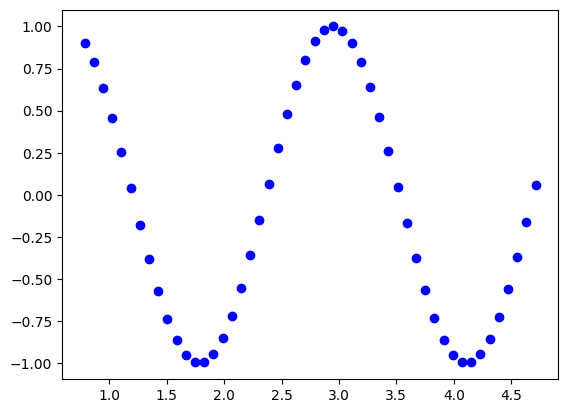

In [4]:
# Armemos los datos a fitear
xx = np.linspace(np.pi/4, (3/2)*np.pi, num=50)
yy = np.sin(2.7*xx - 0.1)

plt.plot(xx, yy, 'bo')

Tiempo de entrenamiento: 0.32796311378479004


(0.0, 1.0)

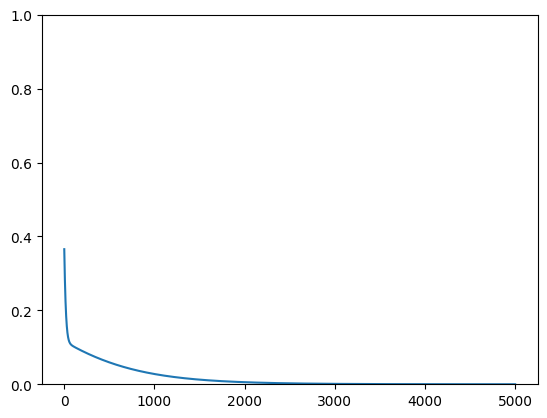

In [8]:
params = np.array([0.8, 2, 1.0]) # con 0.8, 2, 1.0 tiende a 0. 
eta = 1e-3
t0 = time.time()
params, log_train = iterative_method(params, xx, yy, func_sin, grad_loss_sin, update_sgd, eta, num_epochs=5000, batch_size=10)
print('Tiempo de entrenamiento:', time.time()-t0)
plt.plot(log_train)
plt.ylim(0,1)

[ 1.00018038  2.69255364 -0.07593434]


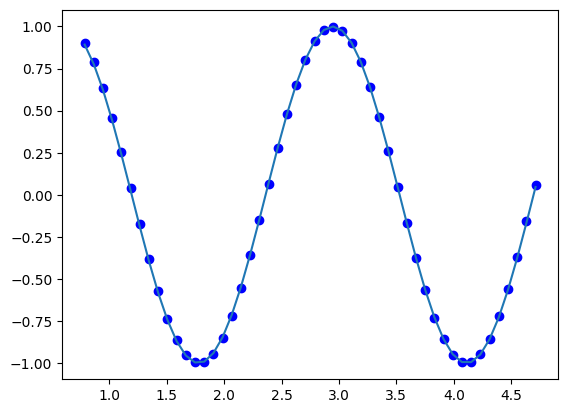

In [9]:
plt.plot(xx, yy, 'bo')
plt.plot(xx, func_sin(params, xx))
print(params)


# Una primera red neuronal

Ahora vamos a probar ajustar una cuadrática, pero utilizando una red neuronal

La red está dada por una concatenación de capas
$$ h = \sigma (W x + b)$$

Las matrices $W$ y los vectores $b$ los vamos a guardar en un solo vector, así es mas fácil implementar el optimizador

In [29]:
# Ahora vamos a usar la librería JAX
from jax import grad, jit, vmap
from jax import random
from jax import nn

# Esta parte la podemos usar como veníamos usando NumPy
import jax.numpy as jnp

import matplotlib.pyplot as plt

# Definimos la arquitectura de la red
layer_sizes = [1, 64, 1]

# Empaqueta los parametros en un solo vector
def pack_params(params):
    return jnp.concatenate([jnp.ravel(w) for w, _ in params] +
                             [jnp.ravel(b) for _, b in params])

# Desempaqueta un vector de parametros con la forma de nuestra red
def unpack_params(params):
    weights = []
    for i in range(len(layer_sizes) - 1):
        weight_size = layer_sizes[i] * layer_sizes[i + 1]
        to_unpack, params = params[:weight_size], params[weight_size:]
        weights.append(jnp.array(to_unpack).reshape(layer_sizes[i + 1], layer_sizes[i]))

    biases = []
    for i in range(len(layer_sizes) - 1):
        bias_size = layer_sizes[i + 1]
        to_unpack, params = params[:bias_size], params[bias_size:]
        biases.append(jnp.array(to_unpack).reshape(layer_sizes[i + 1]))

    params = [(w, b) for w, b in zip(weights, biases)]
    return params

# Genera parametros aleatorios
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    scale = jnp.sqrt(2.0 / (m + n))
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    # return jnp.ones((n, m)), jnp.zeros((n,))

# Inicializa los parámetros de la red
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


In [30]:
# La red neuronal
@jit
def predict(params, coord):
    params = unpack_params(params)
    hidden = coord
    for w, b in params[:-1]:
        outputs = jnp.dot(w, hidden) + b
        hidden = nn.elu(outputs)

    final_w, final_b = params[-1]
    output = jnp.dot(final_w, hidden) + final_b
    return output

# Al hacer SGD vamos a querer evaluar muchas coords para los mimos params
# Creamos una version vectorizada del predict
batched_predict = vmap(predict, in_axes=(None, 0))

# La funcion de costo
def loss(params, coord, target):
    preds = batched_predict(params, coord)
    return jnp.mean(jnp.square(preds - target))


In [47]:
# El optimizador 

# Lo cambio por RMSPROP

@jit
def update_rms(params, x, y, step,aux):
    beta = 0.9
    delta=1e-8
    grads  = grad(loss)(params, x, y)
    aux= beta*aux+(1-beta)*(grads**2)
    vect_steps=step/(jnp.sqrt(aux)+delta)

    params = params-vect_steps *grads
    ##params = [pp - st * gg for pp, gg,st in zip(params, grads,vect_steps)]
    return jnp.array(params),aux


@jit
def update_sgd(params, x, y, step):
    grads  = grad(loss)(params, x, y)
    params=params -step*grads
    #params = [pp - step * gg for pp, gg in zip(params, grads)]
    return jnp.array(params)

def get_batches(x, y, bs):
    for i in range(0, len(x), bs):
        yield x[i:i+bs], y[i:i+bs]

In [48]:
# Generamos datos
#Como modificar esto para implementar RMSPROP
xx = jnp.linspace(-1, 1).reshape(-1, 1)
yy = xx**2

# Inicialiamos parámetros d ela red
num_epochs = 2000
params = init_network_params(layer_sizes, random.key(0))
params = pack_params(params)

# Inicialiamos el optimizador
update = update_sgd
step_size = 0.01


# Inicialiamos el optimizador
update = update_rms
#xi,yi=get_batches(xx,yy,bs=2)
grads=grad(loss)(params,xx,yy)
aux=grads**2
step_size = 0.001

# Entrenamos!
log_train = []
for epoch in range(num_epochs):
    for xi, yi in get_batches(xx, yy, bs=2):
        params,aux= update(params, xx, yy, step_size,aux)
    train_loss = loss(params, xx, yy)
    log_train.append(train_loss)



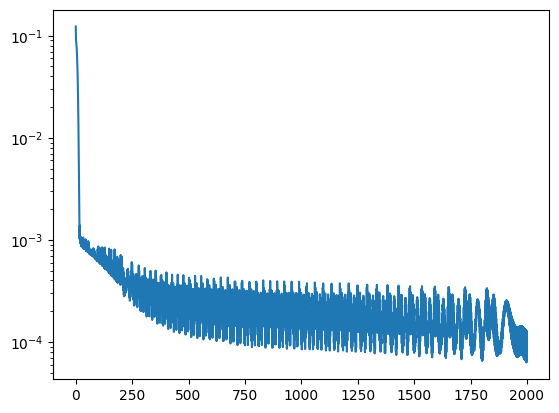

In [49]:
# Plot loss function
plt.semilogy(log_train)

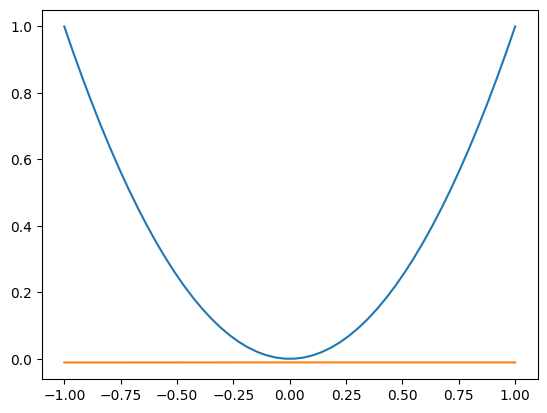

In [33]:
# Plot results
plt.plot(xx, yy)
plt.plot(xx, batched_predict(params, xx))

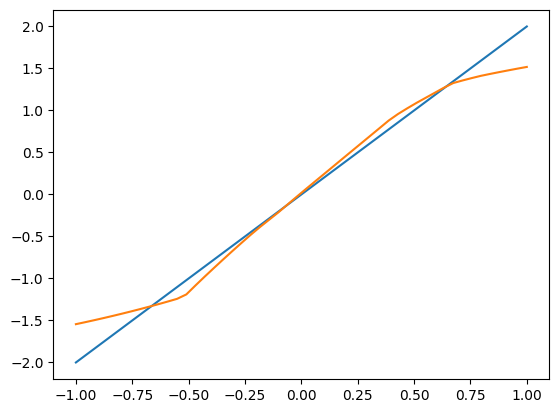

In [ ]:
# Plot derivative
scalar_predict  = lambda params, coords: predict(params, coords)[0]
batched_gradient = vmap(grad(scalar_predict, argnums=1), in_axes=(None, 0))
plt.plot(xx, 2*xx)
plt.plot(xx, batched_gradient(params, xx))